# Let's make histograms for $20 \times 25$ Logbins

In [1]:
base_directory = '/home/shoaib/ZTFDataChallenge/'

import sys
sys.path.insert(0, base_directory + 'dmdt_Analysis/')
from dmdt_functions import *

In [2]:
import numpy as np
import pandas as pd
from os import listdir

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=5)

from tqdm.auto import tqdm
tqdm.pandas(desc="Lightcurves Processed")

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
plt.rcParams['axes.grid'] = False
# plt.style.use('seaborn-v0_8-colorblind')

INFO: Pandarallel will run on 5 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
qso_types = ['Q', 'QR', 'QX']

In [4]:
lightcurves_by_name = pd.read_pickle(base_directory + 'lightcurves_by_name_1day_binned.pkl').dropna()
lightcurves_by_name = lightcurves_by_name[lightcurves_by_name['type'].isin(qso_types)]
### Sampling to save disk space
fraction = 0.1
all_object_names = lightcurves_by_name['name'].unique()
sampled_object_names = np.random.choice(all_object_names, size=int(len(all_object_names) * fraction), replace=False)
lightcurves_by_name = lightcurves_by_name[lightcurves_by_name['name'].isin(sampled_object_names)]

lightcurves_by_oid = pd.read_pickle(base_directory + 'lightcurves_by_oid_1day_binned.pkl').dropna()
lightcurves_by_oid = lightcurves_by_oid[lightcurves_by_oid['type'].isin(qso_types)]
### Sampling to save disk space
fraction = 0.1
all_oids = lightcurves_by_oid['oid_alerce'].unique()
sampled_oids = np.random.choice(all_oids, size=int(len(all_oids) * fraction), replace=False)
lightcurves_by_oid = lightcurves_by_oid[lightcurves_by_oid['oid_alerce'].isin(sampled_oids)]

In [5]:
def mean_density(lightcurve):
    mean = np.mean(lightcurve[:, 1])
    lightcurve[:, 1] = lightcurve[:, 1] / mean
    lightcurve[:, 2] = lightcurve[:, 2] / mean
    return lightcurve

In [6]:
lightcurves_by_name['r_lightcurve_mean_normed'] = lightcurves_by_name['r_lightcurve'].progress_apply(mean_norm)
lightcurves_by_name['g_lightcurve_mean_normed'] = lightcurves_by_name['g_lightcurve'].progress_apply(mean_norm) 
lightcurves_by_name['r_lightcurve_1day_binned_mean_normed'] = lightcurves_by_name['r_lightcurve_1day_binned'].progress_apply(mean_norm)
lightcurves_by_name['g_lightcurve_1day_binned_mean_normed'] = lightcurves_by_name['g_lightcurve_1day_binned'].progress_apply(mean_norm)

lightcurves_by_oid['lightcurve_mean_normed'] = lightcurves_by_oid['lightcurve'].progress_apply(mean_norm) 
lightcurves_by_oid['lightcurve_1day_binned_mean_normed'] = lightcurves_by_oid['lightcurve_1day_binned'].progress_apply(mean_norm)

Lightcurves Processed:   0%|          | 0/2328 [00:00<?, ?it/s]

Lightcurves Processed:   0%|          | 0/2328 [00:00<?, ?it/s]

Lightcurves Processed:   0%|          | 0/2328 [00:00<?, ?it/s]

Lightcurves Processed:   0%|          | 0/2328 [00:00<?, ?it/s]

Lightcurves Processed:   0%|          | 0/8573 [00:00<?, ?it/s]

Lightcurves Processed:   0%|          | 0/8573 [00:00<?, ?it/s]

/home/shoaib/miniforge3/envs/PSC/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/shoaib/miniforge3/envs/PSC/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [7]:
def return_histogram(lightcurve, dm_bins, dt_bins):
    histogram, _, _ = get_dmdt_histogram(lightcurve[:, 1], dm_bins, lightcurve[:, 0], dt_bins)
    return histogram

Loading the bins

In [8]:
### Making the bins
dm_bins = np.linspace(-0.05, 0.05, 21)
dt_bins = np.logspace(0, np.log10(1200), 26)

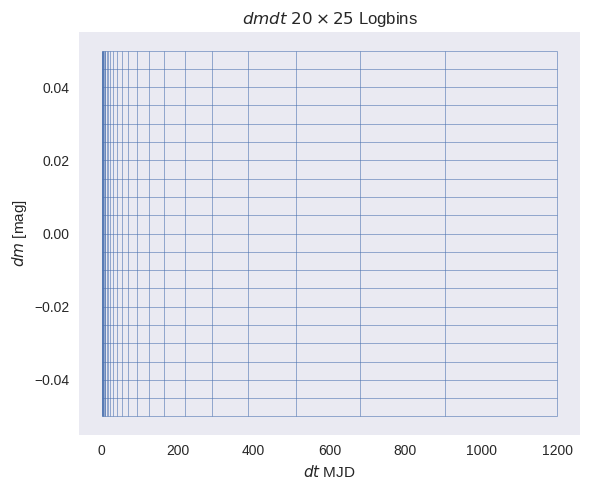

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

ax.hlines(dm_bins, dt_bins.min(), dt_bins.max(), linewidth=0.4)
ax.vlines(dt_bins, dm_bins.min(), dm_bins.max(), linewidth=0.4)
ax.set_title('$dmdt$ $20 \\times 25$ Logbins')
ax.set_xlabel('$dt$ MJD')
ax.set_ylabel('$dm$ [mag]')

plt.tight_layout()
plt.show()

## By Name

In [10]:
lightcurves_by_name['r_histogram_1day_cadence'] = lightcurves_by_name['r_lightcurve_1day_binned_mean_normed'].parallel_apply(lambda lightcurve: return_histogram(lightcurve, dm_bins, dt_bins))
lightcurves_by_name['g_histogram_1day_cadence'] = lightcurves_by_name['g_lightcurve_1day_binned_mean_normed'].parallel_apply(lambda lightcurve: return_histogram(lightcurve, dm_bins, dt_bins))

lightcurves_by_name['r_histogram_original_cadence'] = lightcurves_by_name['r_lightcurve_mean_normed'].parallel_apply(lambda lightcurve: return_histogram(lightcurve, dm_bins, dt_bins))
lightcurves_by_name['g_histogram_original_cadence'] = lightcurves_by_name['g_lightcurve_mean_normed'].parallel_apply(lambda lightcurve: return_histogram(lightcurve, dm_bins, dt_bins))

In [11]:
# lightcurves_by_name.to_pickle(base_directory + 'dmdt_Analysis/20x25_LogBins/20x25_logbin_histograms_by_name.pkl')

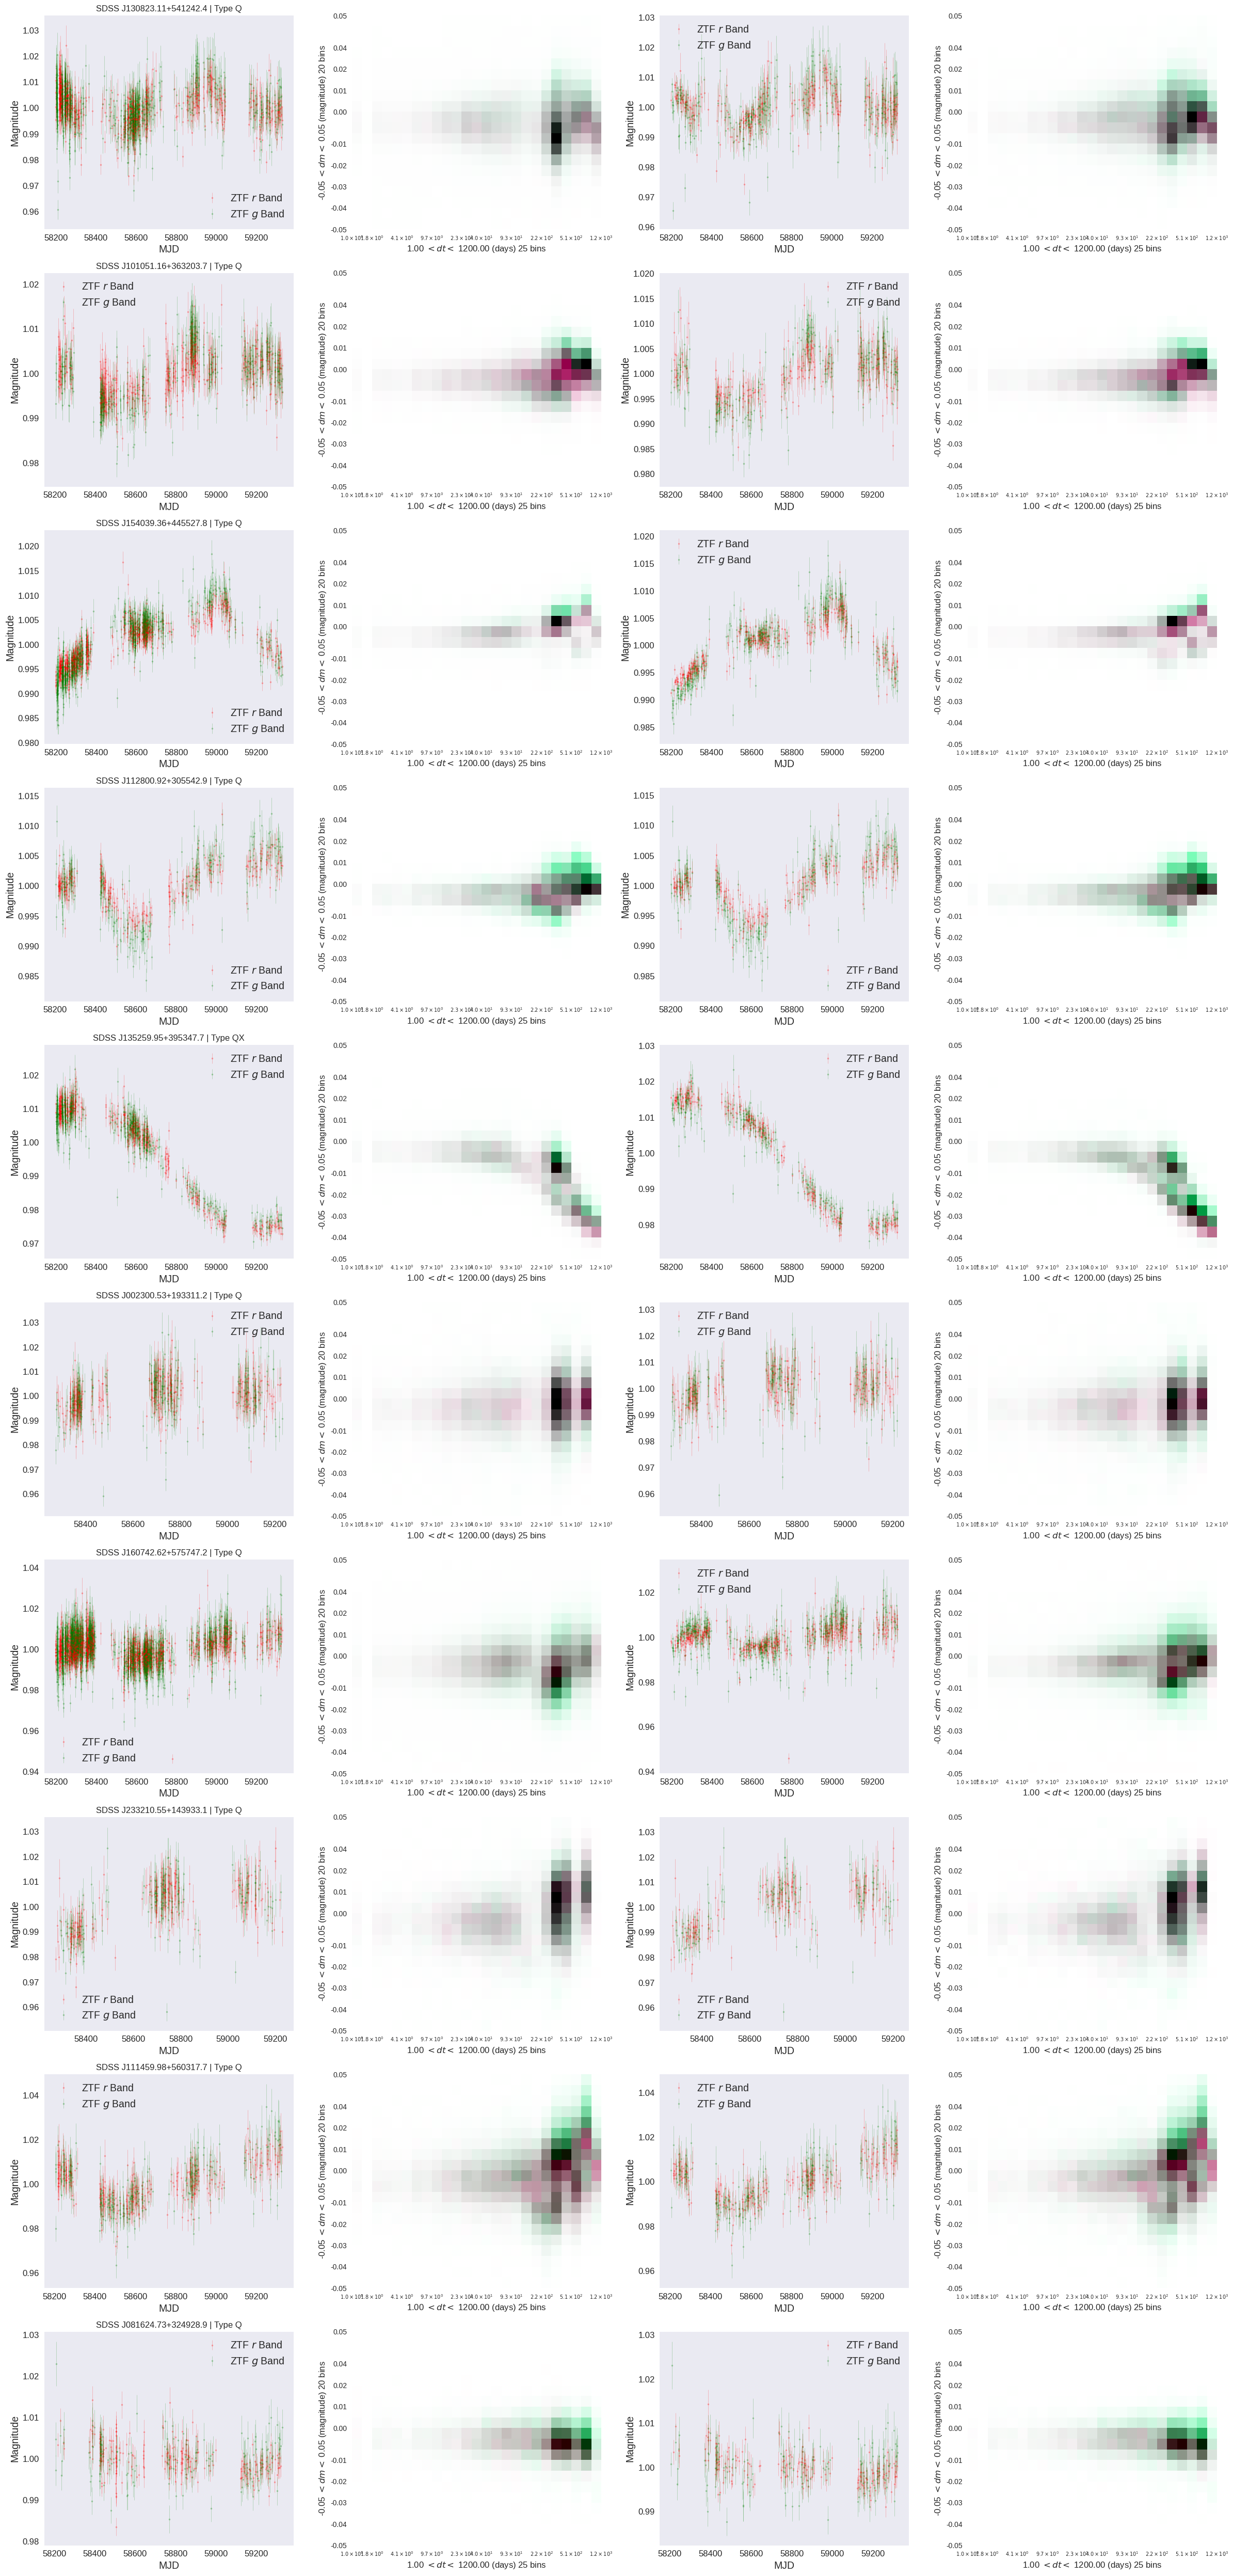

In [12]:
num_examples = 10
sample_df_by_name = lightcurves_by_name[lightcurves_by_name['type'].isin(qso_types)].sample(num_examples)
sample_df_by_oid = lightcurves_by_oid[lightcurves_by_oid['type'].isin(qso_types)].sample(num_examples)

fig, axs = plt.subplots(nrows=num_examples, ncols=4, figsize=(6 * 4, num_examples * 5))

for i, ax_row in enumerate(axs):
    object_name = sample_df_by_name['name'].iloc[i]
    object_type = sample_df_by_name['type'].iloc[i]
    object_lightcurve_r_original = sample_df_by_name['r_lightcurve_mean_normed'].iloc[i]
    object_lightcurve_g_original = sample_df_by_name['g_lightcurve_mean_normed'].iloc[i]
    object_lightcurve_r_1day = sample_df_by_name['r_lightcurve_1day_binned_mean_normed'].iloc[i]
    object_lightcurve_g_1day = sample_df_by_name['g_lightcurve_1day_binned_mean_normed'].iloc[i]
    object_histogram_r_original_cadence = sample_df_by_name['r_histogram_original_cadence'].iloc[i]
    object_histogram_g_original_cadence = sample_df_by_name['g_histogram_original_cadence'].iloc[i]
    object_histogram_r_1day_cadence = sample_df_by_name['r_histogram_1day_cadence'].iloc[i]
    object_histogram_g_1day_cadence = sample_df_by_name['g_histogram_1day_cadence'].iloc[i]
    ax_row[0].set_title(f'{object_name} | Type {object_type}')
    draw_single_axis_both_bands(ax_row[0], object_lightcurve_r_original, object_lightcurve_g_original)
    draw_showcase_histogram(ax_row[1], object_histogram_r_original_cadence, object_histogram_g_original_cadence, dm_bins, dt_bins)
    draw_single_axis_both_bands(ax_row[2], object_lightcurve_r_1day, object_lightcurve_g_1day)
    draw_showcase_histogram(ax_row[3], object_histogram_r_1day_cadence, object_histogram_g_1day_cadence, dm_bins, dt_bins)

    plt.tight_layout()

## By OID

In [13]:
lightcurves_by_oid['histogram_1day_cadence'] = lightcurves_by_oid['lightcurve_1day_binned_mean_normed'].parallel_apply(lambda lightcurve: return_histogram(lightcurve, dm_bins, dt_bins))
lightcurves_by_oid['histogram_original_cadence'] = lightcurves_by_oid['lightcurve_mean_normed'].parallel_apply(lambda lightcurve: return_histogram(lightcurve, dm_bins, dt_bins))

In [14]:
# lightcurves_by_oid.to_pickle(base_directory + 'dmdt_Analysis/20x25_LogBins/20x25_logbin_histograms_by_oid.pkl')

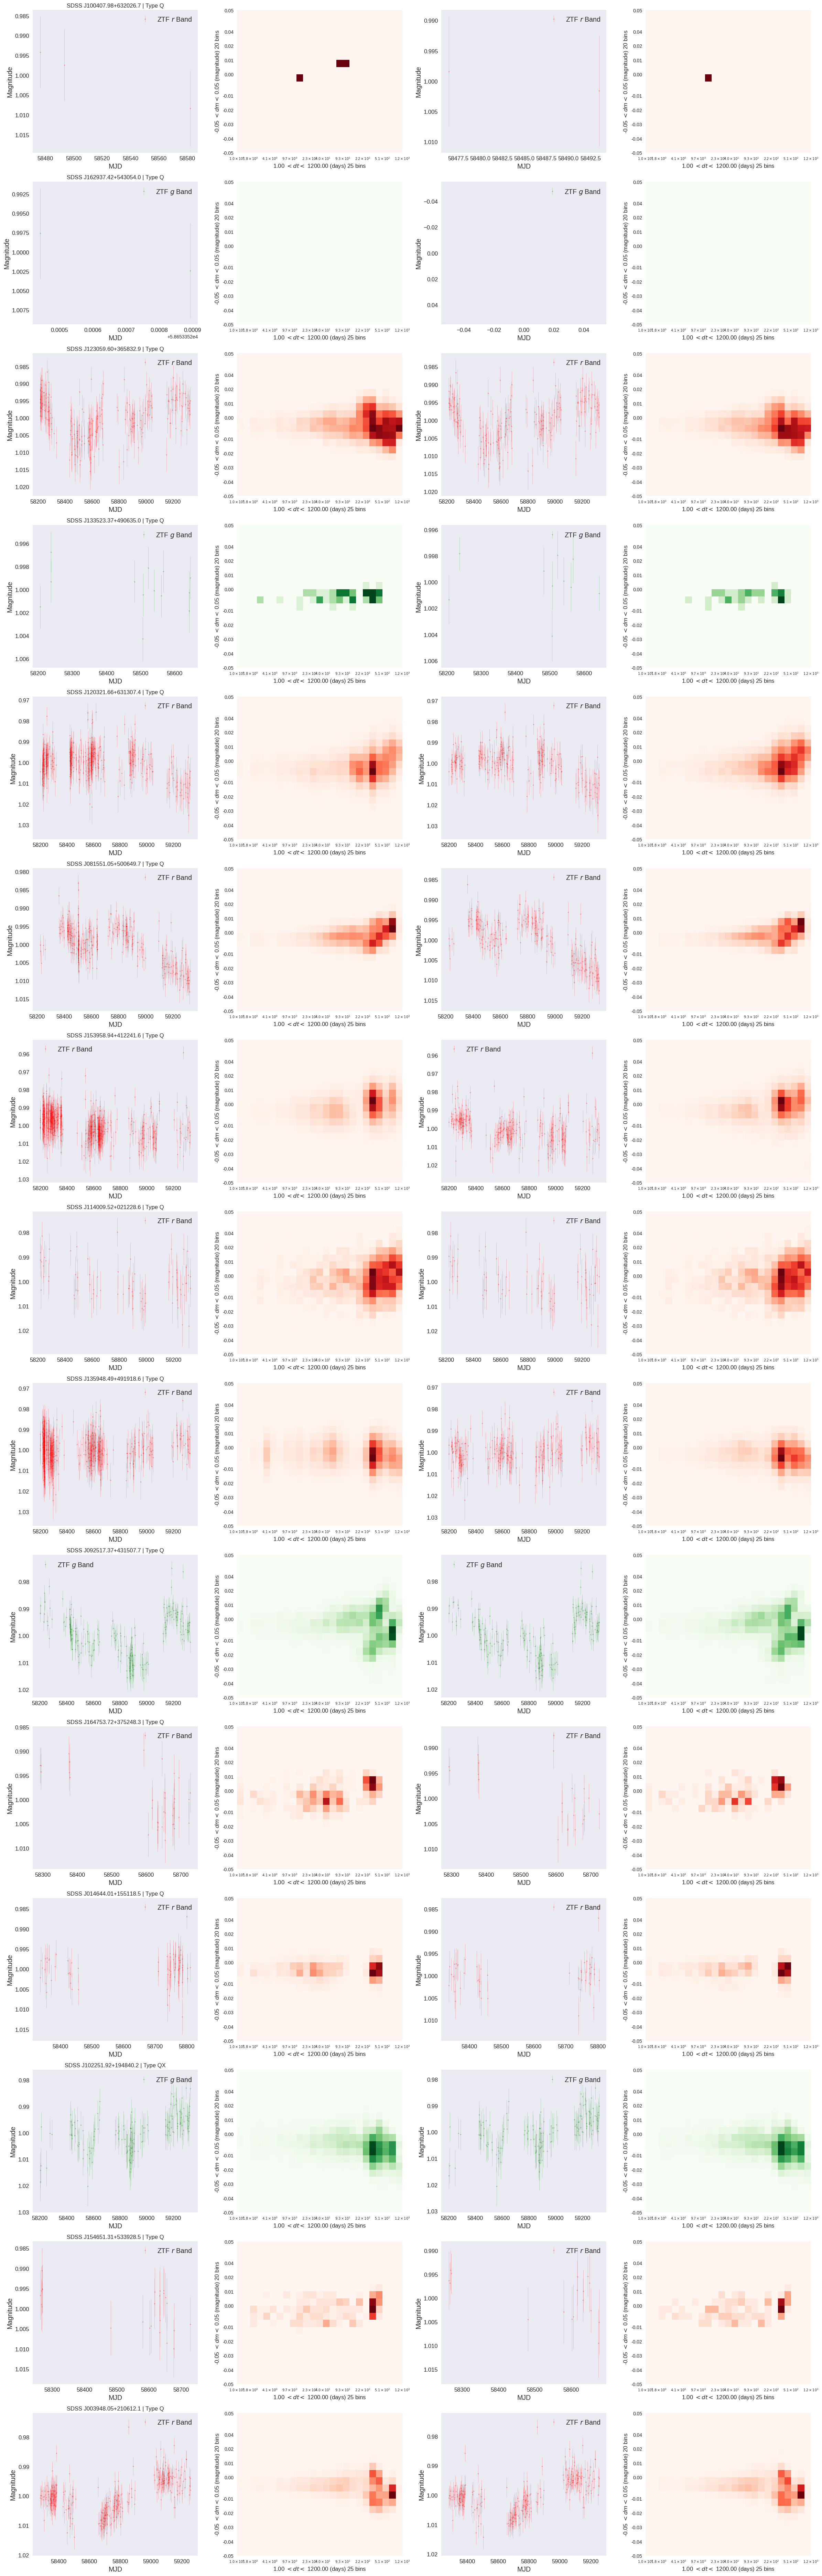

In [15]:
num_examples = 15
sample_df_by_name = lightcurves_by_name[lightcurves_by_name['type'].isin(qso_types)].sample(num_examples)
sample_df_by_oid = lightcurves_by_oid[lightcurves_by_oid['type'].isin(qso_types)].sample(num_examples)

fig, axs = plt.subplots(nrows=num_examples, ncols=4, figsize=(6 * 4, num_examples * 5))

for i, ax_row in enumerate(axs):
    oid = sample_df_by_oid['oid_alerce'].iloc[i]
    oid_name = sample_df_by_oid['name'].iloc[i]
    oid_type = sample_df_by_oid['type'].iloc[i]
    oid_band = sample_df_by_oid['band'].iloc[i]
    oid_lightcurve_original = sample_df_by_oid['lightcurve_mean_normed'].iloc[i]
    oid_lightcurve_1day = sample_df_by_oid['lightcurve_1day_binned_mean_normed'].iloc[i]
    oid_histogram_original_cadence = sample_df_by_oid['histogram_original_cadence'].iloc[i]
    oid_histogram_1day_cadence = sample_df_by_oid['histogram_1day_cadence'].iloc[i]
    ax_row[0].set_title(f'{oid_name} | Type {oid_type}')
    draw_single_axis_single_band(ax_row[0], oid_band, oid_lightcurve_original)
    draw_single_channel_dmdt_histogram(ax_row[1], oid_histogram_original_cadence, oid_band, dm_bins, dt_bins)
    draw_single_axis_single_band(ax_row[2], oid_band, oid_lightcurve_1day)
    draw_single_channel_dmdt_histogram(ax_row[3], oid_histogram_1day_cadence, oid_band, dm_bins, dt_bins)
    
    plt.tight_layout()